# a spring coupled mass simulator to create positions of mechanisms and purviews of a CES 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext blackcellmagic

In [3]:
import numpy as np
import math
import pickle as pkl
from scipy.special import comb

from pyphi import visualize as viz
from pyphi import relations as rel

import matplotlib.pyplot as plt
import string

import random
import imageio


Welcome to PyPhi!

If you use PyPhi in your research, please cite the paper:

  Mayner WGP, Marshall W, Albantakis L, Findlay G, Marchman R, Tononi G.
  (2018). PyPhi: A toolbox for integrated information theory.
  PLOS Computational Biology 14(7): e1006343.
  https://doi.org/10.1371/journal.pcbi.1006343

Documentation is available online (or with the built-in `help()` function):
  https://pyphi.readthedocs.io

To report issues, please use the issue tracker on the GitHub repository:
  https://github.com/wmayner/pyphi

For general discussion, you are welcome to join the pyphi-users group:
  https://groups.google.com/forum/#!forum/pyphi-users

To suppress this message, either:
  - Set `WELCOME_OFF: true` in your `pyphi_config.yml` file, or
  - Set the environment variable PYPHI_WELCOME_OFF to any value in your shell:
        export PYPHI_WELCOME_OFF='yes'



ModuleNotFoundError: No module named 'imageio'

In [ ]:
def strip_punct(s):
    return str(
        s.translate(str.maketrans({key: None for key in string.punctuation})).replace(
            " ", ""
        )
    )

def compute_forces(
    x,
    y,
    z,
    vx,
    vy,
    vz,
    spring_constants,
    friction_factor=1,
    repulsion_factor=1,
    spring_factor=1,
):

    N = len(x)
    Fx = []
    Fy = []
    Fz = []
    for i in range(N):

        F = np.zeros(3)
        for j in range(N):
            if i != j:
                # computing distance
                distance_vector = [x[i] - x[j], y[i] - y[j], z[i] - z[j]]
                distance = np.sqrt(np.sum([d ** 2 for d in distance_vector]))
                distance = distance if distance>0.1 else 0.1
                unit_vector = [d / distance for d in distance_vector]

                # computing spring forces
                spring_force_magnitude = (
                    distance * spring_constants[i, j] * spring_factor
                )
                spring_force_vector = np.array(
                    [-spring_force_magnitude * u for u in unit_vector]
                )

                # computing repulsive force
                repulsive_force_magnitude = np.sum(spring_constants[j,:]) * repulsion_factor / (distance**2) / N
                repulsive_force_vector = np.array(
                    [repulsive_force_magnitude * u for u in unit_vector]
                )

                # summing total forces
                F += spring_force_vector + repulsive_force_vector

        # computing friction force
        total_speed = np.sqrt(vx[i] ** 2 + vy[i] ** 2 + vz[i] ** 2)
        friction_magnitude = total_speed * friction_factor
        friction_vector = np.array(
            [
                friction_magnitude * v / total_speed if total_speed > 0 else 0
                for v in [vx[i], vy[i], vz[i]]
            ]
        )
        
        Fx.append(F[0] - friction_vector[0])
        Fy.append(F[1] - friction_vector[1])
        Fz.append(F[2] - friction_vector[2])

    return Fx, Fy, Fz


def update_position_and_velocity(x, y, z, vx, vy, vz, Fx, Fy, Fz, delta, mass=None):
    if mass == None:
        mass = np.ones(len(x))

    for i in range(len(x)):
        ax = Fx[i] / mass[i]
        ay = Fy[i] / mass[i]
        az = Fz[i] / mass[i]
        vx[i] = vx[i] + (ax * delta)
        vy[i] = vy[i] + (ay * delta)
        vz[i] = vz[i] + (az * delta)
        x[i] = x[i] + (vx[i] * delta)
        y[i] = y[i] + (vy[i] * delta)
        z[i] = z[i] + (vz[i] * delta)

    return x, y, z, vx, vy, vz


def equilibrate(
    spring_constants,
    x,
    y,
    z=None,
    vx=None,
    vy=None,
    vz=None,
    friction_factor=2,
    repulsion_factor=1,
    spring_factor=1,
    T=100,
    delta=0.1,
    mass=None,
    immovable=[]
):
    if z is None:
        z = np.zeros(len(x))
    if vx is None:
        vx = np.zeros(len(x))
    if vy is None:
        vy = np.zeros(len(x))
    if vz is None:
        vz = np.zeros(len(x))

    path = []
    for t in range(T):
        Fx, Fy, Fz = compute_forces(
            x,
            y,
            z,
            vx,
            vy,
            vz,
            spring_constants,
            friction_factor,
            repulsion_factor,
            spring_factor,
        )
        
        # removing forces and velocities from immovable components
        for i in immovable:
            Fx[i],Fy[i],Fz[i],vx[i],vy[i],vz[i] = 0,0,0,0,0,0
        
        x, y, z, vx, vy, vz = update_position_and_velocity(
            x, y, z, vx, vy, vz, Fx, Fy, Fz, delta, mass
        )
        
        path.append([x.copy(), y.copy(), z.copy()])

    return np.array(path)


def initialize_positions(ces, center=(1, 1), z=0, radius=1,purview_scale=0.9,mech_base=True):
    
    if mech_base:
        aux = construct_mechanism_base(len(ces[-1].mechanism),center,0.1,0.1)
        mechs = [m for mm in aux for m in mm]
    else:
        mechs = viz.regular_polygon(
            len(ces), center=center, angle=0, z=0, radius=radius, scale=1
        )
        
    purviews = viz.regular_polygon(
        2 * len(ces),
        center=center,
        angle=math.pi / (len(ces)),
        z=0,
        radius=radius,
        scale=purview_scale,
    )
    
    xyz = np.array(mechs + purviews)
    
    return (xyz[:,0],xyz[:,1],xyz[:,2])


def get_interactions(ces, rels, adjustment_factor=1):

    separated_ces = rel.separate_ces(ces)
    N = len(ces)
    M = len(separated_ces)

    # denote what components each purview will be affected by
    # first the mechanisms
    features_mechs = np.zeros((M, N))
    for i in range(N):
        features_mechs[2 * i : 2 * i + 2, i] = 1

    # next the relations
    features_rels = viz.feature_matrix(rel.separate_ces(ces), rels)
    features_rels = viz.feature_matrix(rel.separate_ces(ces), rels)
    # features now contains information about any distinction or relation each purview is associated to
    # next, we exchange the 1's with phi values
    # frist for distinctions
    for i in range(M):
        features_mechs[i, :] *= separated_ces[i].phi

    for i in range(len(rels)):
        features_rels[:, i] *= rels[i].phi / len(rels[i].relata)

    # getting the interactions between constituents
    interactions = np.zeros((N + M, N + M))

    # filling with mechanism-purview interactions
    interactions[N:, :N] = features_mechs
    interactions[:N, N:] = np.transpose(features_mechs)

    # now for the purview-purview interactions
    purview_purview = np.zeros((M, M))
    for i, feature in enumerate(features_rels):
        for r in feature.nonzero()[0]:
            for j in features_rels[:, r].nonzero()[0]:
                if not i == j:
                    purview_purview[i, j] += feature[r]
                    purview_purview[j, i] += feature[r]

    # renormalizing to have same max as mechanisms interactions
    purview_purview = (
        adjustment_factor
        * np.max(interactions[N:, :N])
        * purview_purview
        / (np.max(np.sum(purview_purview, axis=1)))
    )

    interactions[N:, N:] = purview_purview

    return interactions/interactions.mean()


def construct_mechanism_base(N,base_center,base_floor_height,base_scale):
    return [
            viz.regular_polygon(
                int(comb(N, k)),
                center=base_center,
                z=((k / N) * base_floor_height),
                scale=base_scale,
            )
        for k in range(1, N + 1)
    ]


# Chapter 3 system

In [11]:
with open(r"ch3_ces.pkl", "rb") as f:
    ces = pkl.load(f)
    
with open(r"ch3_rels.pkl", "rb") as f:
    rels = pkl.load(f)
    
with open(r"ch3_subsystem.pkl", "rb") as f:
    system = pkl.load(f)

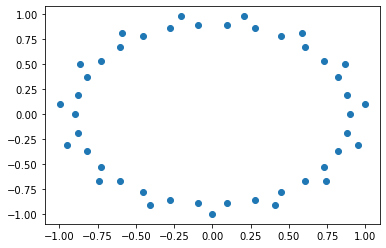

In [12]:

spring_constants = get_interactions(ces, rels, 0.5)
x,y,z = initialize_positions(ces, center=(0,0), z=0, radius=1,purview_scale=0.9,mech_base=False)
plt.scatter(x,y)
plt.show()
#x,y,z = np.random.random(len(x)),np.random.random(len(x)),np.random.random(len(x))

T= 300
path = equilibrate(
    spring_constants,
    x,
    y,
    z,
    vx=None,
    vy=None,
    vz=None,
    friction_factor=5,
    repulsion_factor=1,
    spring_factor=1,
    T=T,
    delta=0.01,
    mass=None,
    immovable=range(len(ces))
)

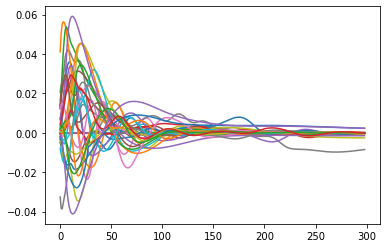

In [13]:
plt.plot(path[:-1,1,:]-path[1:,1,:]);

In [27]:
labels = [strip_punct(str(system.indices2nodes(c.mechanism))) for c in ces]+[strip_punct(str(system.indices2nodes(c.purview))) for c in rel.separate_ces(ces)]

mech_coords = [path[-1,0,:len(ces)].tolist(),path[-1,1,:len(ces)].tolist(),path[-1,2,:len(ces)].tolist()]
purv_coords = np.array([path[-1,0,len(ces):].tolist(),path[-1,1,len(ces):].tolist(),path[-1,2,len(ces):].tolist()]).transpose()

In [18]:
fig = viz.plot_ces_epicycles(system,ces,rels,network_name='ch3_spring_random_static_mechs_small',
                             user_mechanism_coords=mech_coords,
                             user_purview_coords=purv_coords,
                             link_width_range=(1,3),
                             eye_coordinates=(0,0,1),
                             mechanism_labels_size=8,
                             purview_labels_size=8,
                             mechanism_label_position='middle center',
                             purview_label_position='middle center',
                             show_purview_labels=False,
                             save_plot_to_html=False,
                             png_name='pngs/ch3/frame1.png',
                             showlegend=False,
                            show_mechanism_labels=False,
                            show_mechanism_state_labels=False,
)

In [28]:
T=300
times = range(0,T,5)

filenames = []
for t in times:
    mech_coords = [path[t,0,:len(ces)].tolist(),path[t,1,:len(ces)].tolist(),path[t,2,:len(ces)].tolist()]
    purv_coords = np.array([path[t,0,len(ces):].tolist(),path[t,1,len(ces):].tolist(),path[t,2,len(ces):].tolist()]).transpose()

    name = "pngs/ch3_circle/frame"+str(t)+".png"
    fig = viz.plot_ces_epicycles(
        system,
        ces,
        rels,
        network_name="ch3_spring_random_static_mechs_small",
        user_mechanism_coords=mech_coords,
        user_purview_coords=purv_coords,
        link_width_range=(1, 3),
        eye_coordinates=(0, 0, 1),
        mechanism_labels_size=8,
        purview_labels_size=8,
        mechanism_label_position="middle center",
        purview_label_position="middle center",
        show_purview_labels=False,
        save_plot_to_html=False,
        png_name=name,
        showlegend=False,
        show_mechanism_labels=False,
        show_mechanism_state_labels=False,
    )
    filenames.append(name)

In [30]:

with imageio.get_writer('pngs/ch3_circle/new.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

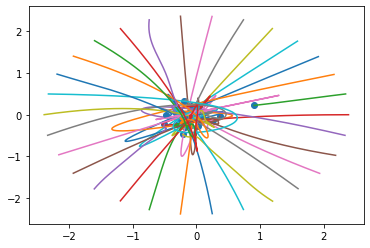

In [77]:
n=15
plt.plot(path[:,0,:],path[:,1,:])
plt.scatter(path[-1,0,:],path[-1,1,:])
plt.show()

# EXPLOSION!

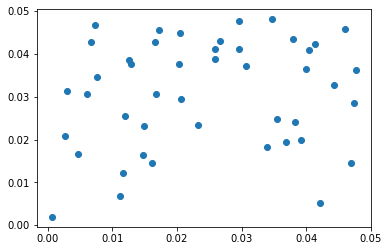

In [14]:

spring_constants = get_interactions(ces, rels, 0.5)
x,y,z = np.random.random(len(x))*0.05,np.random.random(len(x))*0.05,np.zeros(len(x))#np.random.random(len(x))*0.1
plt.scatter(x,y)
plt.show()
delta=0.01

T1=10
T2=100
T3=190
# First explode mechanisms
path1 = equilibrate(
    spring_constants,
    x,
    y,
    z,
    vx=None,
    vy=None,
    vz=None,
    friction_factor=5,
    repulsion_factor=1,
    spring_factor=1,
    T=T1,
    delta=0.01,
    mass=None,
    immovable=range(len(ces),3*len(ces))
)

# next include purviews in the explosion
path2 = equilibrate(
    spring_constants,
    path1[-1,0,:],
    path1[-1,1,:],
    path1[-1,2,:],
    (path1[-1,0,:]-path1[-2,0,:])/delta,
    (path1[-1,1,:]-path1[-2,1,:])/delta,
    (path1[-1,2,:]-path1[-2,2,:])/delta,
    friction_factor=5,
    repulsion_factor=1,
    spring_factor=1,
    T=T2,
    delta=0.01,
    mass=None,
    immovable=[]
)

# finally, bind mechanism positions
path3 = equilibrate(
    spring_constants,
    path2[-1,0,:],
    path2[-1,1,:],
    path2[-1,2,:],
    (path2[-1,0,:]-path2[-2,0,:])/delta,
    (path2[-1,1,:]-path2[-2,1,:])/delta,
    (path2[-1,2,:]-path2[-2,2,:])/delta,
    friction_factor=5,
    repulsion_factor=1,
    spring_factor=1,
    T=T3,
    delta=0.01,
    mass=None,
    immovable=range(len(ces))
)

In [15]:
path = np.concatenate((path1,path2,path3),axis=0)

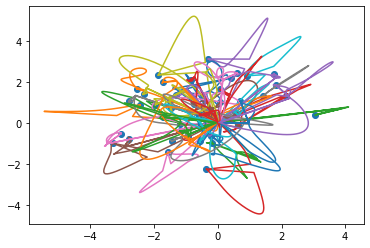

In [16]:
n=15
plt.plot(path[:,0,:],path[:,1,:])
plt.scatter(path[-1,0,:],path[-1,1,:])
plt.show()

In [44]:
T=T1+T2+T3
times = range(0,T,5)

filenames = []
for t in times:
    mech_coords = [path[t,0,:len(ces)].tolist(),path[t,1,:len(ces)].tolist(),path[t,2,:len(ces)].tolist()]
    purv_coords = np.array([path[t,0,len(ces):].tolist(),path[t,1,len(ces):].tolist(),path[t,2,len(ces):].tolist()]).transpose()

    name = "pngs/ch3_explosion/frame"+str(t)+".png"
    fig = viz.plot_ces_epicycles(
        system,
        ces,
        rels,
        network_name="ch3_spring_random_static_mechs_small",
        user_mechanism_coords=mech_coords,
        user_purview_coords=purv_coords,
        link_width_range=(1, 3),
        eye_coordinates=(0, 0, 1),
        mechanism_labels_size=8,
        purview_labels_size=8,
        mechanism_label_position="middle center",
        purview_label_position="middle center",
        show_purview_labels=False,
        save_plot_to_html=False,
        png_name=name,
        showlegend=False,
        show_mechanism_labels=False,
        show_mechanism_state_labels=False,
    )
    filenames.append(name)

    
with imageio.get_writer('pngs/ch3_explosion/new.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

In [45]:

with imageio.get_writer('pngs/ch3_explosion/new.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# ring of mechanisms with a purview singularit

[[0.20791169081775931, 0.9781476007338057, 0], [0.5877852522924731, 0.8090169943749475, 0], [0.8660254037844386, 0.5000000000000001, 0], [0.9945218953682733, 0.10452846326765346, 0], [0.9510565162951536, -0.30901699437494734, 0], [0.7431448254773945, -0.6691306063588579, 0], [0.40673664307580043, -0.9135454576426008, 0], [5.66553889764798e-16, -1.0, 0], [-0.4067366430757998, -0.9135454576426011, 0], [-0.743144825477394, -0.6691306063588585, 0], [-0.9510565162951535, -0.30901699437494756, 0], [-0.9945218953682734, 0.10452846326765299, 0], [-0.8660254037844386, 0.5000000000000001, 0], [-0.5877852522924734, 0.8090169943749473, 0], [-0.20791169081775987, 0.9781476007338056, 0]]


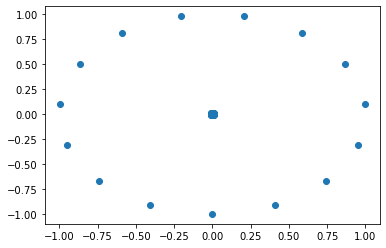

In [52]:

spring_constants = get_interactions(ces, rels, 0.5)
x,y,z = initialize_positions(ces, center=(0,0), z=0, radius=1,purview_scale=0.01,mech_base=False)
plt.scatter(x,y)
plt.show()
delta=0.01

T=300
# First explode mechanisms
path = equilibrate(
    spring_constants,
    x,
    y,
    z,
    vx=None,
    vy=None,
    vz=None,
    friction_factor=5,
    repulsion_factor=1,
    spring_factor=1,
    T=T,
    delta=0.01,
    mass=None,
    immovable=range(len(ces))
)


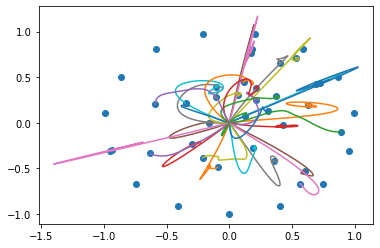

In [53]:
n=15
plt.plot(path[:,0,:],path[:,1,:])
plt.scatter(path[-1,0,:],path[-1,1,:])
plt.show()

In [54]:

times = range(0,T,5)

filenames = []
for t in times:
    mech_coords = [path[t,0,:len(ces)].tolist(),path[t,1,:len(ces)].tolist(),path[t,2,:len(ces)].tolist()]
    purv_coords = np.array([path[t,0,len(ces):].tolist(),path[t,1,len(ces):].tolist(),path[t,2,len(ces):].tolist()]).transpose()

    name = "pngs/ch3_purview_singularity/frame"+str(t)+".png"
    fig = viz.plot_ces_epicycles(
        system,
        ces,
        rels,
        network_name="ch3_spring_random_static_mechs_small",
        user_mechanism_coords=mech_coords,
        user_purview_coords=purv_coords,
        link_width_range=(1, 3),
        eye_coordinates=(0, 0, 1),
        mechanism_labels_size=8,
        purview_labels_size=8,
        mechanism_label_position="middle center",
        purview_label_position="middle center",
        show_purview_labels=False,
        save_plot_to_html=False,
        png_name=name,
        showlegend=False,
        show_mechanism_labels=False,
        show_mechanism_state_labels=False,
    )
    filenames.append(name)

In [55]:

with imageio.get_writer('pngs/ch3_purview_singularity/new.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

In [62]:
mech_z = [-np.min(s[s>0]) for s in spring_constants[:len(ces),:]]

In [63]:
mech_z

[64.31489313102348,
 7.629250553395768,
 64.31489313102348,
 1.4995172538562282,
 2.7481445753694094,
 10.16474738547653,
 2.1848331608207014,
 2.7481445753694094,
 0.39697774104912503,
 2.1848331608207014,
 10.291515610784883,
 0.816053909683318,
 1.7371745948309714,
 0.816053909683318,
 2.9596013854349104]

In [64]:
mech_z = [-np.min(s[s>0]) for s in spring_constants[:len(ces),:]]
purv_z = [np.sum(s[s>0]) for s in spring_constants[len(ces):,:]]
mech_coords = [path[t,0,:len(ces)].tolist(),path[t,1,:len(ces)].tolist(),mech_z]
purv_coords = np.array([path[t,0,len(ces):].tolist(),path[t,1,len(ces):].tolist(),purv_z]).transpose()


fig = viz.plot_ces_epicycles(
    system,
    ces,
    rels,
    network_name="ch3_spring_jeremiah_z",
    user_mechanism_coords=mech_coords,
    user_purview_coords=purv_coords,
    link_width_range=(1, 3),
    eye_coordinates=(0, 0, 1),
    mechanism_labels_size=8,
    purview_labels_size=8,
    mechanism_label_position="middle center",
    purview_label_position="middle center",
    show_purview_labels=False,
    save_plot_to_html=True,
    png_name=name,
    showlegend=False,
    show_mechanism_labels=False,
    show_mechanism_state_labels=False,
)

# 6node space

In [4]:
with open(r"4.0_example_6-nodes_ces.pkl", "rb") as f:
    ces = pkl.load(f)
    
with open(r"4.0_example_6-nodes_subsystem.pkl", "rb") as f:
    system = pkl.load(f)
    
with open(r"4.0_example_6-nodes_relations.pkl", "rb") as f:    
    #This file includes all 2-relations (~30k)
    all_rels = pkl.load(f)  

FileNotFoundError: [Errno 2] No such file or directory: '4.0_example_6-nodes_ces.pkl'

In [18]:
rels = [r for r in all_rels if len(r.mechanisms)==2]

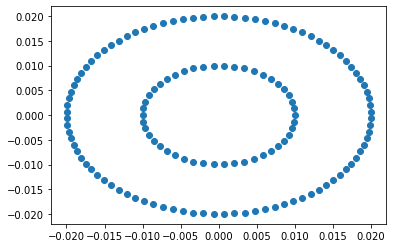

In [30]:

spring_constants = get_interactions(ces, all_rels, 0.5)
x,y,z = initialize_positions(ces, center=(0,0), z=0, radius=0.01,purview_scale=2,mech_base=False)
#z[len(ces):] = np.random.randn(len(ces)*2)
plt.scatter(x,y)
plt.show()
delta=0.01

T=300
# First explode mechanisms
path = equilibrate(
    spring_constants,
    x,
    y,
    z,
    vx=None,
    vy=None,
    vz=None,
    friction_factor=5,
    repulsion_factor=1,
    spring_factor=1,
    T=T,
    delta=0.01,
    mass=None,
    immovable=range(len(ces))
)

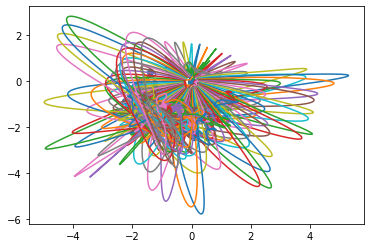

In [31]:
n=15
plt.plot(path[:,0,:],path[:,1,:])
plt.scatter(path[-1,0,:],path[-1,1,:])
plt.show()

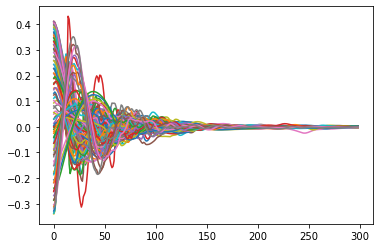

In [32]:
plt.plot(path[:-1,1,:]-path[1:,1,:]);

In [22]:
times = range(0,T,5)
axes_range = [
    (np.min(path[:,i,:]),np.max(path[:,i,:])) for i in range(3)
]

filenames = []
for t in times:
    mech_coords = [path[t,0,:len(ces)].tolist(),path[t,1,:len(ces)].tolist(),path[t,2,:len(ces)].tolist()]
    purv_coords = np.array([path[t,0,len(ces):].tolist(),path[t,1,len(ces):].tolist(),path[t,2,len(ces):].tolist()]).transpose()

    name = "pngs/koosh_with_added_repulsion/frame"+str(t)+".png"
    fig = viz.plot_ces_epicycles(
        system,
        ces,
        rels,
        network_name="ch3_spring_random_static_mechs_small",
        user_mechanism_coords=mech_coords,
        user_purview_coords=purv_coords,
        link_width_range=(1, 3),
        eye_coordinates=(0, 0, 1),
        mechanism_labels_size=8,
        purview_labels_size=8,
        mechanism_label_position="middle center",
        purview_label_position="middle center",
        show_purview_labels=False,
        save_plot_to_html=False,
        png_name=name,
        showlegend=False,
        show_mechanism_labels=False,
        show_mechanism_state_labels=False,
        plot_dimensions=(600,600),
        axes_range=axes_range
    )
    filenames.append(name)
    
with imageio.get_writer('pngs/koosh_with_added_repulsion/new.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

In [33]:
axes_range = [
    (np.min(path[:,i,:]),np.max(path[:,i,:])) for i in range(3)
]

mech_coords = [path[-1,0,:len(ces)].tolist(),path[-1,1,:len(ces)].tolist(),path[-1,2,:len(ces)].tolist()]
purv_coords = np.array([path[-1,0,len(ces):].tolist(),path[-1,1,len(ces):].tolist(),path[-1,2,len(ces):].tolist()]).transpose()

name = "pngs/koosh_with_added_repulsion/final.png"

fig = viz.plot_ces_epicycles(
    system,
    ces,
    rels,
    network_name="ch3_spring_random_static_mechs_small",
    user_mechanism_coords=mech_coords,
    user_purview_coords=purv_coords,
    link_width_range=(1, 3),
    eye_coordinates=(0, 0, 1),
    mechanism_labels_size=8,
    purview_labels_size=8,
    mechanism_label_position="middle center",
    purview_label_position="middle center",
    show_purview_labels=True,
    save_plot_to_html=False,
    png_name=name,
    showlegend=False,
    show_mechanism_labels=False,
    show_mechanism_state_labels=False,
    plot_dimensions=(600,600),
    axes_range=axes_range
)

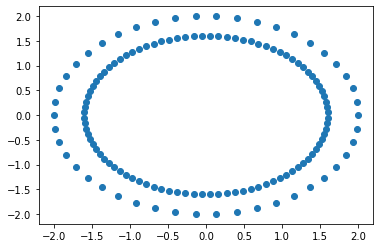

In [23]:

spring_constants = get_interactions(ces, all_rels, 0.5)
x,y,z = initialize_positions(ces, center=(0,0), z=0, radius=2,purview_scale=0.8,mech_base=False)
#z[len(ces):] = np.random.randn(len(ces)*2)
plt.scatter(x,y)
plt.show()
delta=0.01

T=300
# First explode mechanisms
path = equilibrate(
    spring_constants,
    x,
    y,
    z,
    vx=None,
    vy=None,
    vz=None,
    friction_factor=5,
    repulsion_factor=1,
    spring_factor=1,
    T=T,
    delta=0.01,
    mass=None,
    immovable=range(len(ces))
)

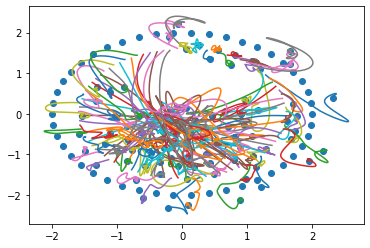

In [24]:
n=15
plt.plot(path[:,0,:],path[:,1,:])
plt.scatter(path[-1,0,:],path[-1,1,:])
plt.show()

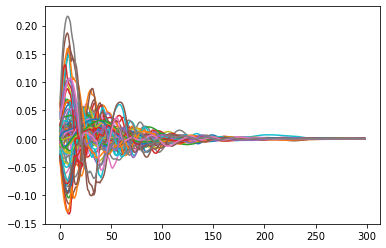

In [25]:
plt.plot(path[:-1,1,:]-path[1:,1,:]);

In [27]:
axes_range

[(-2.121162785609654, 2.554624234176439),
 (-2.469136734780433, 2.4020993666230197),
 (0.0, 0.0)]

In [26]:
times = range(0,T,5)
axes_range = [
    (np.min(path[:,i,:]),np.max(path[:,i,:])) for i in range(3)
]

filenames = []
for t in times:
    mech_coords = [path[t,0,:len(ces)].tolist(),path[t,1,:len(ces)].tolist(),path[t,2,:len(ces)].tolist()]
    purv_coords = np.array([path[t,0,len(ces):].tolist(),path[t,1,len(ces):].tolist(),path[t,2,len(ces):].tolist()]).transpose()

    name = "pngs/mech_outside_with_added_repulsion/frame"+str(t)+".png"
    fig = viz.plot_ces_epicycles(
        system,
        ces,
        rels,
        network_name="ch3_spring_random_static_mechs_small",
        user_mechanism_coords=mech_coords,
        user_purview_coords=purv_coords,
        link_width_range=(1, 3),
        eye_coordinates=(0, 0, 1),
        mechanism_labels_size=8,
        purview_labels_size=8,
        mechanism_label_position="middle center",
        purview_label_position="middle center",
        show_purview_labels=False,
        save_plot_to_html=False,
        png_name=name,
        showlegend=False,
        show_mechanism_labels=False,
        show_mechanism_state_labels=False,
        plot_dimensions=(600,600),
        axes_range=axes_range
    )
    filenames.append(name)
    
with imageio.get_writer('pngs/mech_outside_with_added_repulsion/new.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

In [21]:
fig = viz.plot_ces_epicycles(
    system,
    ces,
    rels,
    network_name="ch3_spring_random_static_mechs_small",
    user_mechanism_coords=mech_coords,
    user_purview_coords=purv_coords,
    link_width_range=(1, 3),
    eye_coordinates=(0, 0, 1),
    mechanism_labels_size=8,
    purview_labels_size=8,
    mechanism_label_position="middle center",
    purview_label_position="middle center",
    show_purview_labels=True,
    save_plot_to_html=False,
    png_name='pngs/grid_mech_inside/final.png',
    showlegend=False,
    show_mechanism_labels=False,
    show_mechanism_state_labels=False,
    plot_dimensions=(800,800),
    axes_range=axes_range
)

In [22]:

mech_coords = [path[-1,0,:len(ces)].tolist(),path[-1,1,:len(ces)].tolist(),path[-1,2,:len(ces)].tolist()]
purv_coords = np.array([path[-1,0,len(ces):].tolist(),path[-1,1,len(ces):].tolist(),path[-1,2,len(ces):].tolist()]).transpose()

fig = viz.plot_ces_epicycles(
    system,
    ces,
    rels,
    network_name="6node_grid_top",
    user_mechanism_coords=mech_coords,
    user_purview_coords=purv_coords,
    link_width_range=(1, 3),
    eye_coordinates=(0, 0, 1),
    mechanism_labels_size=8,
    purview_labels_size=8,
    mechanism_label_position="middle center",
    purview_label_position="middle center",
    show_purview_labels=False,
    save_plot_to_html=False,
    showlegend=False,
    show_mechanism_labels=True,
    show_mechanism_state_labels=False,
    hovermode=False,
    png_name="6node_grid_top.png",
    plot_dimensions=(800,800),
)

In [24]:
ces[0].mechanism

(0,)

In [23]:

fig = viz.plot_ces_epicycles(
    system,
    ces,
    rels,
    network_name="6node_grid_side",
    user_mechanism_coords=mech_coords,
    user_purview_coords=purv_coords,
    link_width_range=(1, 3),
    eye_coordinates=(0, 1, 0),
    mechanism_labels_size=8,
    purview_labels_size=8,
    mechanism_label_position="middle center",
    purview_label_position="middle center",
    show_purview_labels=False,
    save_plot_to_html=False,
    showlegend=False,
    show_mechanism_labels=True,
    show_mechanism_state_labels=False,
    hovermode=False,
    png_name="6node_grid_side.png",
    plot_dimensions=(800,800),
)

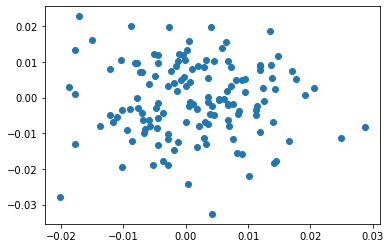

In [24]:

spring_constants = get_interactions(ces, rels, 0.5)
x,y,z = np.random.randn(len(ces)*3)*0.01,np.random.randn(len(ces)*3)*0.01,np.random.randn(len(ces)*3)*0.01,
plt.scatter(x,y)
plt.show()
delta=0.01

T1=10
T2=100
T3=190
# First explode mechanisms
path1 = equilibrate(
    spring_constants,
    x,
    y,
    z,
    vx=None,
    vy=None,
    vz=None,
    friction_factor=5,
    repulsion_factor=1,
    spring_factor=1,
    T=T1,
    delta=0.01,
    mass=None,
    immovable=range(len(ces),3*len(ces))
)

# next include purviews in the explosion
path2 = equilibrate(
    spring_constants,
    path1[-1,0,:],
    path1[-1,1,:],
    path1[-1,2,:],
    (path1[-1,0,:]-path1[-2,0,:])/delta,
    (path1[-1,1,:]-path1[-2,1,:])/delta,
    (path1[-1,2,:]-path1[-2,2,:])/delta,
    friction_factor=5,
    repulsion_factor=1,
    spring_factor=1,
    T=T2,
    delta=0.01,
    mass=None,
    immovable=[]
)

# finally, bind mechanism positions
path3 = equilibrate(
    spring_constants,
    path2[-1,0,:],
    path2[-1,1,:],
    path2[-1,2,:],
    (path2[-1,0,:]-path2[-2,0,:])/delta,
    (path2[-1,1,:]-path2[-2,1,:])/delta,
    (path2[-1,2,:]-path2[-2,2,:])/delta,
    friction_factor=5,
    repulsion_factor=1,
    spring_factor=1,
    T=T3,
    delta=0.01,
    mass=None,
    immovable=range(len(ces))
)

In [27]:
path = np.concatenate((path1,path2,path3),axis=0)
mech_coords = [path[-1,0,:len(ces)].tolist(),path[-1,1,:len(ces)].tolist(),path[-1,2,:len(ces)].tolist()]
purv_coords = np.array([path[-1,0,len(ces):].tolist(),path[-1,1,len(ces):].tolist(),path[-1,2,len(ces):].tolist()]).transpose()

fig = viz.plot_ces_epicycles(
    system,
    ces,
    rels,
    network_name="6node_grid_side",
    user_mechanism_coords=mech_coords,
    user_purview_coords=purv_coords,
    link_width_range=(1, 3),
    eye_coordinates=(0, 1, 0),
    mechanism_labels_size=8,
    purview_labels_size=8,
    mechanism_label_position="middle center",
    purview_label_position="middle center",
    show_purview_labels=False,
    save_plot_to_html=False,
    showlegend=False,
    show_mechanism_labels=True,
    show_mechanism_state_labels=False,
    hovermode=False,
    png_name="6node_grid_becoming.png",
    plot_dimensions=(800,800),
)

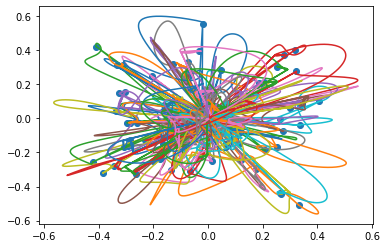

In [28]:
n=15
plt.plot(path[:,0,:],path[:,1,:])
plt.scatter(path[-1,0,:],path[-1,1,:])
plt.show()

In [30]:
times = range(0,T,5)

filenames = []
for t in times:
    mech_coords = [path[t,0,:len(ces)].tolist(),path[t,1,:len(ces)].tolist(),path[t,2,:len(ces)].tolist()]
    purv_coords = np.array([path[t,0,len(ces):].tolist(),path[t,1,len(ces):].tolist(),path[t,2,len(ces):].tolist()]).transpose()

    name = "pngs/grid_becoming/frame"+str(t)+".png"
    fig = viz.plot_ces_epicycles(
        system,
        ces,
        rels,
        network_name="ch3_spring_random_static_mechs_small",
        user_mechanism_coords=mech_coords,
        user_purview_coords=purv_coords,
        link_width_range=(1, 3),
        eye_coordinates=(0, 0, 1),
        mechanism_labels_size=8,
        purview_labels_size=8,
        mechanism_label_position="middle center",
        purview_label_position="middle center",
        show_purview_labels=False,
        save_plot_to_html=False,
        png_name=name,
        showlegend=False,
        show_mechanism_labels=False,
        show_mechanism_state_labels=False,
        plot_dimensions=(600,600)
    )
    filenames.append(name)


NameError: name 'imageio' is not defined

In [34]:

    
with imageio.get_writer('pngs/grid_becoming/new.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Space

## All 2-rels

In [50]:
with open(r"space_ces_with_nodelabels.pkl", "rb") as f:
    ces = pkl.load(f)
    
with open(r"space_subsystem.pkl", "rb") as f:
    system = pkl.load(f)
    
with open(r"space_2relations.pkl", "rb") as f:    
    #This file includes all 2-relations (~30k)
    tworels = pkl.load(f)  
sample2rels = random.sample(tworels,5000)

In [51]:
rels = tworels

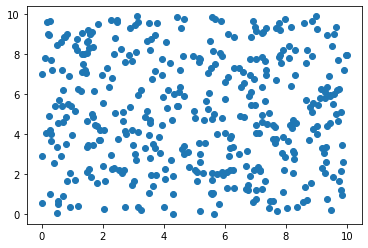

In [52]:
x, y, z = initialize_positions(ces)
x, y, z = np.random.random(len(x))*10,np.random.random(len(x))*10,np.random.random(len(x))*10

plt.scatter(x,y)
plt.show()

In [58]:

spring_constants = get_interactions(ces,rels)

path = equilibrate(
    spring_constants,
    x,
    y,
    z=None,
    vx=None,
    vy=None,
    vz=None,
    friction_factor=10,
    repulsion_factor=0.1,
    spring_factor=1,
    T=1000,
    delta=0.01,
    mass=None
)


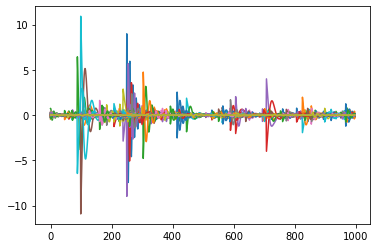

In [59]:
plt.plot(path[:-1,1,:]-path[1:,1,:]);

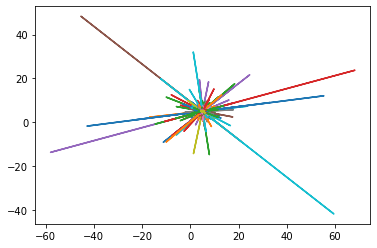

In [60]:
n=15
plt.plot(path[:,0,:],path[:,1,:])
plt.scatter(path[-1,0,:],path[-1,1,:])
plt.show()

In [61]:
labels = [strip_punct(str(system.indices2nodes(c.mechanism))) for c in ces]+[strip_punct(str(system.indices2nodes(c.purview))) for c in rel.separate_ces(ces)]

mech_coords = [x[:len(ces)],y[:len(ces)],np.zeros(len(ces))]
purv_coords = np.array([
    [x[len(ces):][i],y[len(ces):][i],z[len(ces):][i]]
     for i in range(2*len(ces))
])

In [62]:
fig = viz.plot_ces_epicycles(system,ces,rels,network_name='space_spring_2rels_new',
                             user_mechanism_coords=mech_coords,
                             user_purview_coords=purv_coords,
                             link_width_range=(1,3),
                             eye_coordinates=(0,0,1),
                             mechanism_labels_size=8,
                             purview_labels_size=8,
                             mechanism_label_position='middle center',
                             purview_label_position='middle center',
                             show_purview_labels='legendonly',
                             show_edges='legendonly',
                             show_links='legendonly'
                            )

In [63]:
fig = viz.plot_ces_epicycles(system,ces,rels,network_name='space_spring_2rels_5k_no_edge_new',
                             user_mechanism_coords=mech_coords,
                             user_purview_coords=purv_coords,
                             link_width_range=(1,3),
                             eye_coordinates=(0,0,1),
                             mechanism_labels_size=8,
                             purview_labels_size=8,
                             mechanism_label_position='middle center',
                             purview_label_position='middle center',
                             show_purview_labels='legendonly',
                             show_edges=False,
                             show_link='legendonly'
                            )

TypeError: plot_ces_epicycles() got an unexpected keyword argument 'show_link'

## Sample 2-rels

In [26]:
with open(r"space_ces_with_nodelabels.pkl", "rb") as f:
    ces = pkl.load(f)
    
with open(r"space_subsystem.pkl", "rb") as f:
    system = pkl.load(f)
    
with open(r"space_2relations.pkl", "rb") as f:    
    #This file includes all 2-relations (~30k)
    tworels = pkl.load(f)  
sample2rels = random.sample(tworels,5000)

In [27]:
rels = sample2rels

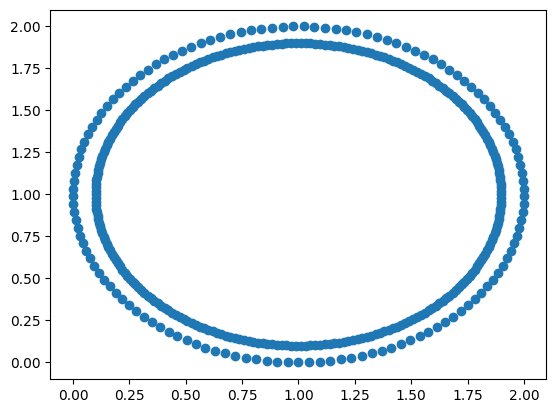

In [11]:
xyz = initialize_positions(ces)

plt.scatter(xyz[:,0],xyz[:,1])
plt.show()

In [12]:


k = get_interactions(ces,rels,adjustment_factor=0.1)

purview_indices = tuple(range(len(ces),len(ces)*3))
x,y,z,px,py,pz = equilibriate(k,purview_indices,xyz[:,0],xyz[:,1],T=100,delta=1,friction_factor=1)


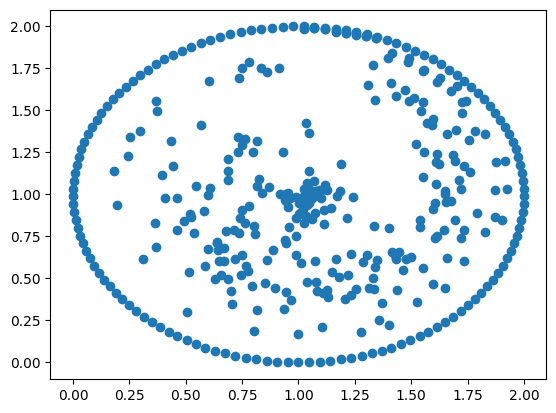

In [13]:

plt.scatter(x,y)
plt.show()

In [14]:
plt.scatter(np.array(px)[:,-10:-1],np.array(py)[:,-10:-1])

In [15]:
plt.plot(np.array(py)[:,-10:-1])

In [16]:
labels = [strip_punct(str(system.indices2nodes(c.mechanism))) for c in ces]+[strip_punct(str(system.indices2nodes(c.purview))) for c in rel.separate_ces(ces)]

mech_coords = [x[:len(ces)],y[:len(ces)],np.zeros(len(ces))]
purv_coords = np.array([
    [x[len(ces):][i],y[len(ces):][i],z[len(ces):][i]]
     for i in range(2*len(ces))
])

In [17]:
k[len(ces):,len(ces):].sum(1)

array([0.00867996, 0.00623701, 0.0042136 , 0.00582657, 0.00752501,
       0.00819592, 0.01379213, 0.01929905, 0.01433153, 0.01287437,
       0.01033035, 0.0067367 , 0.00720318, 0.00900732, 0.00464563,
       0.007862  , 0.01294898, 0.01953735, 0.00425015, 0.00305002,
       0.02900348, 0.02738943, 0.00268185, 0.0035292 , 0.02053944,
       0.0263382 , 0.00446168, 0.00375105, 0.01644689, 0.03000059,
       0.00336387, 0.00431193, 0.02006654, 0.02448575, 0.00235966,
       0.00451436, 0.02065238, 0.02758311, 0.00404232, 0.00346564,
       0.01000285, 0.01659616, 0.01991695, 0.02688588, 0.01044078,
       0.01526237, 0.00510251, 0.0285511 , 0.00260634, 0.00574669,
       0.02670199, 0.03032434, 0.01732668, 0.03653792, 0.01158917,
       0.0270565 , 0.00165054, 0.00358734, 0.02439882, 0.0530341 ,
       0.01943616, 0.03332512, 0.01524731, 0.02770497, 0.00189616,
       0.00452634, 0.03609287, 0.02921965, 0.02695304, 0.02812873,
       0.01013505, 0.0337259 , 0.00317321, 0.00303215, 0.02639

In [20]:
fig = viz.plot_ces_epicycles(system,ces,rels,network_name='space_spring_sample2rels',
                             user_mechanism_coords=mech_coords,
                             user_purview_coords=purv_coords,
                             link_width_range=(1,3),
                             edge_size_range=(0.1, 1),
                             eye_coordinates=(0,0,1),
                             mechanism_labels_size=8,
                             purview_labels_size=8,
                             mechanism_label_position='middle center',
                             purview_label_position='middle center',
                             show_purview_labels='legendonly',
                             show_edges=True,
                             show_links='legendonly'
                            )

Computing edges:   0%|          | 0/5000 [00:00<?, ?it/s]

In [18]:
fig = viz.plot_ces_epicycles(system,ces,rels,network_name='space_spring_sample2rels_purvs',
                             user_mechanism_coords=mech_coords,
                             user_purview_coords=purv_coords,
                             link_width_range=(1,3),
                             eye_coordinates=(0,0,1),
                             mechanism_labels_size=8,
                             purview_labels_size=8,
                             mechanism_label_position='middle center',
                             purview_label_position='middle center',
                             show_purview_labels=True,
                             show_edges=False,
                             show_links='legendonly'
                            )

In [22]:
fig = viz.plot_ces_epicycles(system,ces,rels,network_name='space_spring_sample2rels_mechfolds',
                             user_mechanism_coords=mech_coords,
                             user_purview_coords=purv_coords,
                             link_width_range=(1,3),
                             eye_coordinates=(0,0,1),
                             mechanism_labels_size=8,
                             purview_labels_size=8,
                             mechanism_label_position='middle center',
                             purview_label_position='middle center',
                             show_purview_labels='legendonly',
                             show_edges='legendonly',
                             show_links='legendonly',
                             show_mechanism_qfolds='legendonly',
                            )

Computing edges:   0%|          | 0/5000 [00:00<?, ?it/s]

# toy example to test code

In [151]:
k = [
    [0,1,2,0,1],
    [1,0,3,2,3],
    [2,3,0,1,2],
    [0,2,1,0,1],
    [1,3,2,1,0]
]
x,y,z,px,py,pz = equilibriate(k,(2,3),[2,1,2,3,4],[0,1,2,3,4],friction_factor=2,delta=0.1)

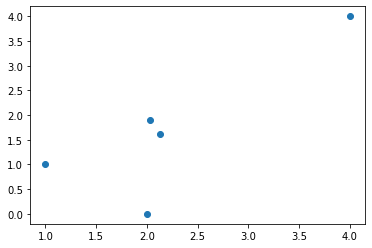

In [152]:
plt.scatter(x,y)

In [153]:
x

[2, 1, 2.129034787874921, 2.0322497560161437, 4]

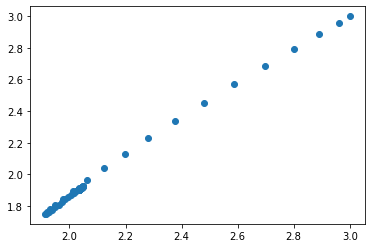

In [154]:
plt.scatter(np.array(px)[:,-2],np.array(py)[:,-2])

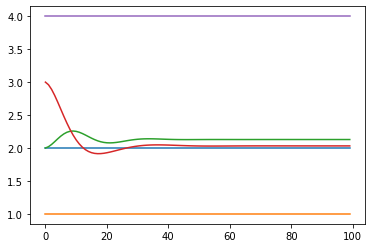

In [155]:
plt.plot(np.array(px))

In [ ]:

def get_interactions(ces, rels, system, adjustment_factor=1):
    
    # determining potential components for a system of this size
    units = len(system)
    max_mechs = 2**units
    max_purvs = max_mechs*2
    
    # create "interaction" matrix, K
    interactions = np.zeros((max_mechs+max_purvs, max_mechs+max_purvs))
    
    # get indices for existing mechanisms and purviews
    separated_ces = rel.separate_ces(ces)
    N = len(ces)
    M = len(separated_ces)
    
    # denote what components each purview will be affected by
    # first the mechanisms
    connection_mechs = np.zeros((M, N))
    for i in range(N):
        connection_mechs[2 * i : 2 * i + 2, i] = 1

    # next the relations
    connection_rels = viz.feature_matrix(separated_ces, rels)
    
    # features now contains information about any distinction or relation each purview is associated to
    # next, we exchange the 1's with phi values
    # frist for distinctions
    for i in range(M):
        connection_mechs[i, :] *= separated_ces[i].phi

    for i in range(len(rels)):
        connection_rels[:, i] *= rels[i].phi / (len(rels[i].relata)-1)

    # filling with mechanism-purview interactions
    interactions[max_mechs:max_mechs+M, :N] = connection_mechs
    interactions[:N, max_mechs:max_mechs+M] = np.transpose(connection_mechs)

    # now for the purview-purview interactions
    purview_purview = np.zeros((M, M))
    for i, connection in enumerate(connection_rels):
        for r in connection.nonzero()[0]:
            for j in connection_rels[:, r].nonzero()[0]:
                if not i == j:
                    purview_purview[i, j] += connection[r]
                    purview_purview[j, i] += connection[r]

    # renormalizing to have same max as mechanisms interactions
    purview_purview = (
        adjustment_factor
        * np.max(interactions)
        * purview_purview
        / (np.max(np.sum(purview_purview, axis=1)))
    )

    interactions[max_mechs:max_mechs+M, max_mechs:max_mechs+M] = purview_purview

    return interactions/interactions.mean()

In [304]:
def strip_punct(s):
    return str(
        s.translate(str.maketrans({key: None for key in string.punctuation})).replace(
            " ", ""
        )
    )

def compute_forces(
    x,
    y,
    z,
    vx,
    vy,
    vz,
    spring_constants,
    friction_factor=1,
    repulsion_factor=1,
    spring_factor=1,
):

    N = len(x)
    Fx = []
    Fy = []
    Fz = []
    for i in range(N):

        F = np.zeros(3)
        for j in range(N):
            if i != j:
                # computing distance
                distance_vector = [x[i] - x[j], y[i] - y[j], z[i] - z[j]]
                distance = np.sqrt(np.sum([d ** 2 for d in distance_vector]))
                unit_vector = [d / distance for d in distance_vector]

                # computing spring forces
                spring_force_magnitude = (
                    distance * spring_constants[i, j] * spring_factor
                )
                spring_force_vector = np.array(
                    [-spring_force_magnitude * u for u in unit_vector]
                )

                # computing repulsive force
                repulsive_force_magnitude = repulsion_factor / (distance**2)
                repulsive_force_vector = np.array(
                    [repulsive_force_magnitude * u for u in unit_vector]
                )

                # summing total forces
                F += spring_force_vector + repulsive_force_vector

        # computing friction force
        total_speed = np.sqrt(vx[i] ** 2 + vy[i] ** 2 + vz[i] ** 2)
        friction_magnitude = total_speed * friction_factor
        friction_vector = np.array(
            [
                friction_magnitude * v / total_speed if total_speed > 0 else 0
                for v in [vx[i], vy[i], vz[i]]
            ]
        )
        
        Fx.append(F[0] - friction_vector[0])
        Fy.append(F[1] - friction_vector[1])
        Fz.append(F[2] - friction_vector[2])

    return Fx, Fy, Fz


def update_position_and_velocity(x, y, z, vx, vy, vz, Fx, Fy, Fz, delta, mass=None):
    if mass == None:
        mass = np.ones(len(x))

    for i in range(len(x)):
        ax = Fx[i] / mass[i]
        ay = Fy[i] / mass[i]
        az = Fz[i] / mass[i]
        vx[i] = vx[i] + (ax * delta)
        vy[i] = vy[i] + (ay * delta)
        vz[i] = vz[i] + (az * delta)
        x[i] = x[i] + (vx[i] * delta)
        y[i] = y[i] + (vy[i] * delta)
        z[i] = z[i] + (vz[i] * delta)

    return x, y, z, vx, vy, vz


def equilibrate(
    spring_constants,
    x,
    y,
    z=None,
    vx=None,
    vy=None,
    vz=None,
    friction_factor=2,
    repulsion_factor=1,
    spring_factor=1,
    T=100,
    delta=0.1,
    mass=None
):
    if z == None:
        z = np.zeros(len(x))
    if vx == None:
        vx = np.zeros(len(x))
    if vy == None:
        vy = np.zeros(len(x))
    if vz == None:
        vz = np.zeros(len(x))

    path = []
    for t in range(T):
        Fx, Fy, Fz = compute_forces(
            x,
            y,
            z,
            vx,
            vy,
            vz,
            spring_constants,
            friction_factor,
            repulsion_factor,
            spring_factor,
        )
        
        x, y, z, vx, vy, vz = update_position_and_velocity(
            x, y, z, vx, vy, vz, Fx, Fy, Fz, delta, mass
        )
        
        path.append([x.copy(), y.copy(), z.copy()])

    return np.array(path)


def initialize_positions(ces, center=(1, 1), z=0, radius=1):
    mechs = viz.regular_polygon(
        len(ces), center=center, angle=0, z=0, radius=radius, scale=1
    )
    purviews = viz.regular_polygon(
        2 * len(ces),
        center=center,
        angle=math.pi / (len(ces)),
        z=0,
        radius=radius,
        scale=0.9,
    )
    
    xyz = np.array(mechs + purviews)
    
    return (xyz[:,0],xyz[:,1],xyz[:,2])


def get_interactions(ces, rels, adjustment_factor=1):

    separated_ces = rel.separate_ces(ces)
    N = len(ces)
    M = len(separated_ces)

    # denote what components each purview will be affected by
    # first the mechanisms
    features_mechs = np.zeros((M, N))
    for i in range(N):
        features_mechs[2 * i : 2 * i + 2, i] = 1

    # next the relations
    features_rels = viz.feature_matrix(rel.separate_ces(ces), rels)
    features_rels = viz.feature_matrix(rel.separate_ces(ces), rels)
    # features now contains information about any distinction or relation each purview is associated to
    # next, we exchange the 1's with phi values
    # frist for distinctions
    for i in range(M):
        features_mechs[i, :] *= separated_ces[i].phi

    for i in range(len(rels)):
        features_rels[:, i] *= rels[i].phi / len(rels[i].relata)

    # getting the interactions between constituents
    interactions = np.zeros((N + M, N + M))

    # filling with mechanism-purview interactions
    interactions[N:, :N] = features_mechs
    interactions[:N, N:] = np.transpose(features_mechs)

    # now for the purview-purview interactions
    purview_purview = np.zeros((M, M))
    for i, feature in enumerate(features_rels):
        for r in feature.nonzero()[0]:
            for j in features_rels[:, r].nonzero()[0]:
                if not i == j:
                    purview_purview[i, j] += feature[r]
                    purview_purview[j, i] += feature[r]

    # renormalizing to have same max as mechanisms interactions
    purview_purview = (
        adjustment_factor
        * np.max(interactions[N:, :N])
        * purview_purview
        / (np.max(np.sum(purview_purview, axis=1)))
    )

    interactions[N:, N:] = purview_purview

    return interactions/interactions.mean()



# Chapter 3 system

In [297]:
with open(r"ch3_ces.pkl", "rb") as f:
    ces = pkl.load(f)
    
with open(r"ch3_rels.pkl", "rb") as f:
    rels = pkl.load(f)
    
with open(r"ch3_subsystem.pkl", "rb") as f:
    system = pkl.load(f)

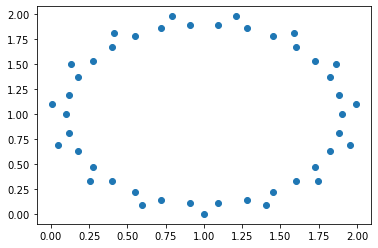

In [298]:
x,y,z = initialize_positions(ces)
plt.scatter(x,y)
plt.show()

In [305]:
k = get_interactions(ces, rels, 0.5)

x,y,z = initialize_positions(ces)

purview_indices = tuple(range(45))
x, y, z, px, py, pz = equilibriate(
    k,
    purview_indices,
    x,
    y,
    T=500,
    friction_factor=1,
    repulsion_factor=1,
    gravitational_factor=0,
    spring_factor=1,
    delta=0.1,
)

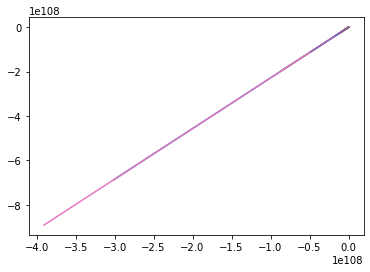

In [306]:
n=15
plt.plot(np.array(px),np.array(py))
plt.show()

In [ ]:
def compute_forces(
    x,
    y,
    z,
    vx,
    vy,
    vz,
    spring_constants,
    friction_factor=1,
    repulsion_factor=1,
    spring_factor=1,
):

    N = len(x)
    Fx = []
    Fy = []
    Fz = []
    for i in range(N):

        F = np.zeros(3)
        for j in range(N):
            if i != j:
                # computing distance
                distance_vector = [x[i] - x[j], y[i] - y[j], z[i] - z[j]]
                distance = np.sqrt(np.sum([d ** 2 for d in distance_vector]))
                unit_vector = [d / distance for d in distance_vector]

                # computing spring forces
                spring_force_magnitude = (
                    distance * spring_constants[i, j] * spring_factor
                )
                spring_force_vector = np.array(
                    [-spring_force_magnitude * u for u in unit_vector]
                )

                # computing repulsive force
                repulsive_force_magnitude = repulsion_factor / (distance**2)
                repulsive_force_vector = np.array(
                    [repulsive_force_magnitude * u for u in unit_vector]
                )

                # summing total forces
                F += spring_force_vector + repulsive_force_vector

        # computing friction force
        total_speed = np.sqrt(vx[i] ** 2 + vy[i] ** 2 + vz[i] ** 2)
        friction_magnitude = total_speed * friction_factor
        friction_vector = np.array(
            [
                friction_magnitude * v / total_speed if total_speed > 0 else 0
                for v in [vx[i], vy[i], vz[i]]
            ]
        )
        
        Fx.append(F[0] - friction_vector[0])
        Fy.append(F[1] - friction_vector[1])
        Fz.append(F[2] - friction_vector[2])

    return Fx, Fy, Fz


def update_position_and_velocity(x, y, z, vx, vy, vz, Fx, Fy, Fz, delta, mass=None):
    if mass == None:
        mass = np.ones(len(x))

    for i in range(len(x)):
        ax = Fx[i] / mass[i]
        ay = Fy[i] / mass[i]
        az = Fz[i] / mass[i]
        vx[i] = vx[i] + (ax * delta)
        vy[i] = vy[i] + (ay * delta)
        vz[i] = vz[i] + (az * delta)
        x[i] = x[i] + (vx[i] * delta)
        y[i] = y[i] + (vy[i] * delta)
        z[i] = z[i] + (vz[i] * delta)

    return x, y, z, vx, vy, vz


def equilibrate(
    spring_constants,
    x,
    y,
    z=None,
    vx=None,
    vy=None,
    vz=None,
    friction_factor=2,
    repulsion_factor=1,
    spring_factor=1,
    T=100,
    delta=0.1,
    mass=None
):
    if z == None:
        z = np.zeros(len(x))
    if vx == None:
        vx = np.zeros(len(x))
    if vy == None:
        vy = np.zeros(len(x))
    if vz == None:
        vz = np.zeros(len(x))

    path = []
    for t in range(T):
        Fx, Fy, Fz = compute_forces(
            x,
            y,
            z,
            vx,
            vy,
            vz,
            spring_constants,
            friction_factor,
            repulsion_factor,
            spring_factor,
        )
        
        x, y, z, vx, vy, vz = update_position_and_velocity(
            x, y, z, vx, vy, vz, Fx, Fy, Fz, delta, mass
        )
        
        path.append([x.copy(), y.copy(), z.copy()])

    return np.array(path)


def initialize_positions(ces, center=(1, 1), z=0, radius=1):
    mechs = viz.regular_polygon(
        len(ces), center=center, angle=0, z=0, radius=radius, scale=1
    )
    purviews = viz.regular_polygon(
        2 * len(ces),
        center=center,
        angle=math.pi / (len(ces)),
        z=0,
        radius=radius,
        scale=0.9,
    )
    
    xyz = np.array(mechs + purviews)
    
    return (xyz[:,0],xyz[:,1],xyz[:,2])

# Chapter 3 system

In [374]:
with open(r"ch3_ces.pkl", "rb") as f:
    ces = pkl.load(f)
    
with open(r"ch3_rels.pkl", "rb") as f:
    rels = pkl.load(f)
    
with open(r"ch3_subsystem.pkl", "rb") as f:
    system = pkl.load(f)

In [375]:

spring_constants = get_interactions(ces, rels, 0.5)
x,y,z = initialize_positions(ces, center=(1, 1), z=0, radius=1)
x,y,z = np.random.random(len(x)),np.random.random(len(x)),np.random.random(len(x))

path = equilibrate(
    spring_constants,
    x,
    y,
    z=None,
    vx=None,
    vy=None,
    vz=None,
    friction_factor=10,
    repulsion_factor=0.1,
    spring_factor=1,
    T=1000,
    delta=0.01,
    mass=None
)

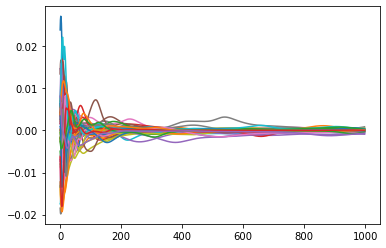

In [378]:
plt.plot(path[:-1,1,:]-path[1:,1,:]);

In [379]:
labels = [strip_punct(str(system.indices2nodes(c.mechanism))) for c in ces]+[strip_punct(str(system.indices2nodes(c.purview))) for c in rel.separate_ces(ces)]

mech_coords = [x[:len(ces)],y[:len(ces)],z[:len(ces)]]
purv_coords = np.array([
    [x[len(ces):][i],y[len(ces):][i],z[len(ces):][i]]
     for i in range(2*len(ces))
])

In [380]:
fig = viz.plot_ces_epicycles(system,ces,rels,network_name='ch3_spring_random',
                             user_mechanism_coords=mech_coords,
                             user_purview_coords=purv_coords,
                             link_width_range=(1,3),
                             eye_coordinates=(0,0,1),
                             mechanism_labels_size=8,
                             purview_labels_size=8,
                             mechanism_label_position='middle center',
                             purview_label_position='middle center',
                             show_purview_labels=True,
)

In [350]:

spring_constants = get_interactions(ces, rels, 0.5)
x,y,z = initialize_positions(ces, center=(1, 1), z=0, radius=1)

N = len(x)
vx = np.zeros(N)
vy = np.zeros(N)
vz = np.zeros(N)

ixs = np.arange(N)

reps = 30
shuffles = [ixs]+[np.random.choice(ixs, size=N,replace=False) for i in range(reps)]

shuffles = [[np.random.random(len(x)),np.random.random(len(x)),np.random.random(len(x))] for i in range(reps)]

tot_F = []
for i,s in enumerate(shuffles):
    Fx,Fy,Fz = compute_forces(
        s[0],
        s[1],
        s[2],
        vx,
        vy,
        vz,
        spring_constants,
        friction_factor=1,
        repulsion_factor=0,
        spring_factor=1,
    )
    
    tot_F.append(np.sum(np.abs(Fx))+np.sum(np.abs(Fy))+np.sum(np.abs(Fz)))



In [351]:
tot_F

[1757.2034705164865,
 1784.3086111815412,
 1867.9325247698605,
 1735.9755244081607,
 1628.4666894115192,
 1731.520211588846,
 2380.50107141981,
 1858.0039314614928,
 1745.294976863499,
 1707.6358299450253,
 1858.3650667225825,
 1666.7745634022672,
 2484.382956331092,
 1962.5573540025423,
 1674.4854221652574,
 1854.5360910635886,
 2076.177996841742,
 1596.7140080472377,
 1643.0785864875652,
 1473.2628889953317,
 1685.1309655374807,
 1520.0179548778076,
 1901.119824161998,
 1808.1115958923756,
 2086.165761175077,
 1385.3030123046897,
 1657.6691645556468,
 1794.7564006485104,
 2090.845995259313,
 2041.7384488551706]

## Sample 2-rels

In [265]:
with open(r"space_ces_with_nodelabels.pkl", "rb") as f:
    ces = pkl.load(f)
    
with open(r"space_subsystem.pkl", "rb") as f:
    system = pkl.load(f)
    
with open(r"space_2relations.pkl", "rb") as f:    
    #This file includes all 2-relations (~30k)
    tworels = pkl.load(f)  
sample2rels = random.sample(tworels,5000)

In [269]:
rels = sample2rels

In [371]:

spring_constants = get_interactions(ces, rels, 0.5)
x,y,z = initialize_positions(ces, center=(1, 1), z=0, radius=1)
#x,y,z = np.random.random(len(x)),np.random.random(len(x)),np.random.random(len(x))

path = equilibrate(
    spring_constants,
    x,
    y,
    z=None,
    vx=None,
    vy=None,
    vz=None,
    friction_factor=1,
    repulsion_factor=0.01,
    spring_factor=200,
    T=10,
    delta=0.1,
    mass=None
)

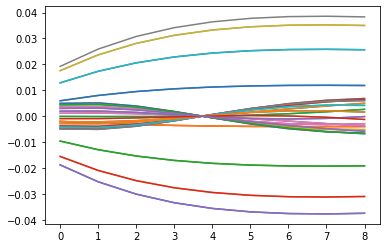

In [372]:
plt.plot(path[:-1,1,:]-path[1:,1,:]);

In [289]:
labels = [strip_punct(str(system.indices2nodes(c.mechanism))) for c in ces]+[strip_punct(str(system.indices2nodes(c.purview))) for c in rel.separate_ces(ces)]

mech_coords = [x[:len(ces)],y[:len(ces)],z[:len(ces)]]
purv_coords = np.array([
    [x[len(ces):][i],y[len(ces):][i],z[len(ces):][i]]
     for i in range(2*len(ces))
])

In [ ]:
fig = viz.plot_ces_epicycles(system,ces,rels,network_name='space_spring_2rels_new',
                             user_mechanism_coords=mech_coords,
                             user_purview_coords=purv_coords,
                             link_width_range=(1,3),
                             eye_coordinates=(0,0,1),
                             mechanism_labels_size=8,
                             purview_labels_size=8,
                             mechanism_label_position='middle center',
                             purview_label_position='middle center',
                             show_purview_labels='legendonly',
                             show_edges='legendonly',
                             show_links='legendonly',
                             Plot_dim
                            )

In [32]:
import pyphi

# determining potential components for a system of this size
units = len(system)
max_mechs = 2**units
max_purvs = max_mechs*2

# create "interaction" matrix, K
K = np.zeros((max_mechs+max_purvs, max_mechs+max_purvs))


In [34]:

def get_interactions(ces, rels, system, adjustment_factor=1):
    
    # determining potential components for a system of this size
    units = len(system)
    max_mechs = 2**units
    max_purvs = max_mechs*2
    
    # create "interaction" matrix, K
    interactions = np.zeros((max_mechs+max_purvs, max_mechs+max_purvs))
    
    # get indices for existing mechanisms and purviews
    separated_ces = rel.separate_ces(ces)
    N = len(ces)
    M = len(separated_ces)
    
    # denote what components each purview will be affected by
    # first the mechanisms
    connection_mechs = np.zeros((M, N))
    for i in range(N):
        connection_mechs[2 * i : 2 * i + 2, i] = 1

    # next the relations
    connection_rels = viz.feature_matrix(separated_ces, rels)
    
    # features now contains information about any distinction or relation each purview is associated to
    # next, we exchange the 1's with phi values
    # frist for distinctions
    for i in range(M):
        connection_mechs[i, :] *= separated_ces[i].phi

    for i in range(len(rels)):
        connection_rels[:, i] *= rels[i].phi / (len(rels[i].relata)-1)

    # filling with mechanism-purview interactions
    interactions[max_mechs:max_mechs+M, :N] = features_mechs
    interactions[:N, max_mechs:max_mechs+M] = np.transpose(features_mechs)

    # now for the purview-purview interactions
    purview_purview = np.zeros((M, M))
    for i, connection in enumerate(connection_rels):
        for r in connection.nonzero()[0]:
            for j in connection_rels[:, r].nonzero()[0]:
                if not i == j:
                    purview_purview[i, j] += connection[r]
                    purview_purview[j, i] += connection[r]

    # renormalizing to have same max as mechanisms interactions
    purview_purview = (
        adjustment_factor
        * np.max(interactions)
        * purview_purview
        / (np.max(np.sum(purview_purview, axis=1)))
    )

    interactions[max_mechs:max_mechs+M, max_mechs:max_mechs+M] = purview_purview

    return interactions/interactions.mean()
